In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.0
sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.19.5
pandas 1.4.3
sklearn 1.1.1
tensorflow 2.6.0
keras.api._v2.keras 2.6.0


In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
#先reshape变为一维的目的是对每一个像素点进行标准化（让其等价）
#同时StandardScaler只能对二维的进行标准化
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [14]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation='selu'))
model.add(keras.layers.Dense(10,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(0.001),
             metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [16]:
model.variables

[<tf.Variable 'dense_21/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[-0.06941696, -0.02066685,  0.03228909, ...,  0.0552683 ,
         -0.06247589,  0.02647922],
        [-0.03114727, -0.00751188,  0.02054373, ...,  0.03179608,
         -0.06947605, -0.06851187],
        [-0.06033279, -0.05468005,  0.06066932, ..., -0.06556608,
         -0.00043184,  0.03802112],
        ...,
        [-0.03604111,  0.03423814, -0.01914564, ...,  0.03069807,
          0.05639292, -0.05519432],
        [-0.00643589,  0.08108504,  0.08204986, ...,  0.048691  ,
         -0.07558315,  0.07896069],
        [ 0.05790429, -0.04549305, -0.00722027, ..., -0.05697756,
         -0.01604432, -0.07053482]], dtype=float32)>,
 <tf.Variable 'dense_21/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [17]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6919 - accuracy: 0.7548 - val_loss: 0.5187 - val_accuracy: 0.8198

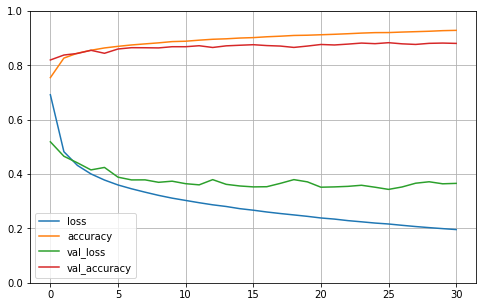

In [18]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    批归一化缓解梯度消失

In [19]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.40265682339668274, 0.866599977016449]